<a href="https://colab.research.google.com/github/indra622/tutorials/blob/master/Multi_AI_Agent_Study/Part3_Ch2_03_Corrective_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q langchain-community langchain-openai python-dotenv chromadb langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 6.3 MB/s eta 0:00:0

In [ ]:
from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

doc_splits = text_splitter.split_documents(docs_list)

vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)

retriever = vectorstore.as_retriever()


In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

class GradeDocuments(BaseModel):
  """ Binary score for relevance check on retrieved documents."""

  binary_score: str = Field(
      description = "Documents are relevant to the question, 'yes' or 'no'"
  )

llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

system = """
  You are a grader assessing relevance of a retrieved document to a user question. \n
  It does not need to be a stringent test. The goal is to filter out erropneous retrievals. \n
  If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
  Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
  """

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}" ),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = 'agent memory'
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

/usr/local/lib/python3.11/dist-packages/langchain_openai/chat_models/base.py:1360: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
<ipython-input-4-05ac5e551402>:31: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)


binary_score='yes'


In [ ]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

prompt = hub.pull('rlm/rag-prompt')

llm = ChatOpenAI(model_name = 'gpt-4o-mini', temperature=0)

def format_docs(docs):
  return "\n\n".join(doc.page_content for doc in docs)


rag_chain = prompt | llm | StrOutputParser()

generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Agent memory in LLM-powered autonomous systems consists of short-term and long-term memory. Short-term memory utilizes in-context learning for immediate tasks, while long-term memory allows agents to retain and recall information over extended periods, often using external storage for efficient retrieval. This dual memory system enhances the agent's ability to learn from past experiences and improve future performance.


In [ ]:

llm = ChatOpenAI(model = 'gpt-4o-mini', temperature = 0)

system = """
  You are a question re-writer that converts an input question to a better version that is optimized \n
  for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        )
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({'question': question})

'What are the key concepts and functionalities of agent memory in artificial intelligence?'

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

In [ ]:
from typing import List, TypedDict

class GraphState(TypedDict):
  """
  Represents the state of our graph.

  Attributes:
    question: question
    generation: LLM generation
    web_search: whether to add search
    documents: list of documents
  """

  question: str
  generation: str
  web_search: str
  documents: List[str]

In [ ]:
from langchain.schema import Document


def retrieve(state):
  """
  Retrieve documents

  Args:
    state (dict): The current graph state

  Returns:
    state (dict): New key added to state, documents, that contains retrieved documents
  """
  print("---RETRIEVE---")
  question = state['question']

  documents = retriever.get_relevant_documents(question)
  return {"documents": documents, "question": question}


def generate(state):

  """
  Generate answer

  Args:
    state (dict): The current graph state

  Returns:
    state (dict): New key added to state, generation, that contains LLM generation
  """

  print("---GENERATE---")
  question = state["question"]
  documents = state['documents']

  generation = rag_chain.invoke({"context": documents, "question": question})

  return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
  """
  Determines whether the retrieved documents are relevant to the question.

  Args:
    state (dict): The current graph state

  Returns:
    state (dict): New key added to state, binary_score, that contains binary score
  """

  print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
  question = state["question"]
  documents = state["documents"]

  filtered_docs = []
  web_search="No"

  for d in documents:
    score = retrieval_grader.invoke(
        {"question": question, "document": d.page_content}
    )


    grade = score.binary_score

    if grade == 'yes':
      print("---GRADE: DOCUMENT RELEVANT---")
      filtered_docs.append(d)

    else:
      print("---GRADE: DOCUMENT NOT RELEVANT---")
      web_search = "yes"
      continue

  return {"documents": filtered_docs, "question": question, "web_search": web_search}


def transform_query(state):
  """
  Transform the query to produce a better question.

  Args:
    state (dict): The current graph state

  Returns:
    state (dict): Updates question key with a re-phrased question
  """

  print("---TRANFORM QUERY---")
  question = state["question"]
  documents = state["documents"]

  better_question = question_rewriter.invoke({"question": question})

  return {"documents": documents, "question": better_question}

def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}


### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    web_search = state["web_search"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [ ]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

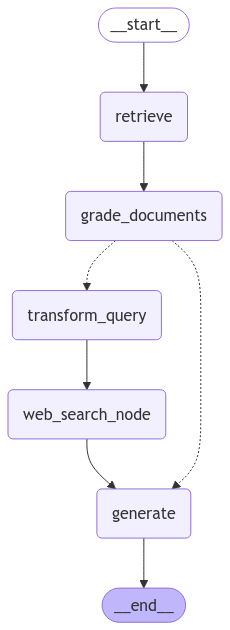

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
# Run
inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node '{key}':")

    print("\n---\n")

# Final generation
print(value["generation"])

---RETRIEVE---
Node 'retrieve':

---

---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
Node 'grade_documents':

---

---GENERATE---
Node 'generate':

---

The types of agent memory are short-term memory and long-term memory. Short-term memory involves in-context learning, while long-term memory allows the agent to retain and recall information over extended periods, often using an external vector store.
